# **MCBS - Final Project** 
## Data pre-processing for Model 1

In [18]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
base_path = "../data/pbc"
orig_data_path  = f"{base_path}/orig"
split_data_path = f"{base_path}/split"
num_of_imgs = 3000
aug_data_path = f"{split_data_path}/train_aug_{num_of_imgs}/"

OVERWRITE = False

classes_dictionary_org = {'BA': 0, 'EO': 1,'ERB': 2,'IG': 3, 'LY': 4, 'MO': 5,'BNE': 6, 'PLATELET': 7 }
classes_dictionary = {value: key for key, value in classes_dictionary_org.items()}

abbreviation_dict = { 'BA':'basophil', 
                      'EO':'eosinophil',
                      'ERB':'erythroblast',
                      'IG':'ig',
                      'LY':'lymphocyte',
                      'MO':'monocyte',
                      'BNE':'neutrophil',
                      'PLATELET': 'platelet' }

In [21]:
def create_directory(directory):
    if os.path.exists(directory):
        if OVERWRITE:
            shutil.rmtree(directory)
            os.mkdir(directory)
    else:
        os.mkdir(directory)

### **Stratified split**

In [7]:
import splitfolders

create_directory(split_data_path)

create_directory(f'{split_data_path}/train')
create_directory(f'{split_data_path}/test')
create_directory(f'{split_data_path}/val')

splitfolders.ratio(orig_data_path, output=split_data_path, seed=1234, ratio=(.8,.1,.1)) 

Copying files: 17092 files [00:01, 9125.58 files/s]


### **Data augmentation**

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def get_number_of_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

def augment_data(directory, new_directory, abbv = "IMG", num_files_goal = 10000):
    
    new_subdirectory = os.path.join(new_directory, directory.split("/")[-1])
    
    print(f"Processing {directory}, augmented data will be saved to {new_subdirectory}.")
    shutil.copytree(directory, new_subdirectory)
    
    datagen = ImageDataGenerator(rotation_range=359,
                                  width_shift_range=0.2,  
                                  height_shift_range=0.2,    
                                  shear_range=0.2,        
                                  zoom_range=0.2,        
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

    images = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    num_files = len(images)
    
    while get_number_of_files(new_subdirectory) < num_files_goal:
        num_files = get_number_of_files(new_subdirectory)
        
        while num_files < num_files_goal:
            file = random.choice(images)
            img = load_img(file)  
            x = img_to_array(img) 
            x = x.reshape((1, ) + x.shape)  
            i = 0

            # generate and save
            for batch in datagen.flow(x, batch_size = 1, 
                                        save_to_dir = new_subdirectory,  
                                        save_prefix =f'AUG_{abbv}',
                                        save_format ='jpg'):
                i += 1
                num_files += 1
                
                if i >= 10: 
                    break

    print(f"Number of files after augmentation: {get_number_of_files(new_subdirectory)}")

In [9]:
num_of_imgs = 3000

create_directory(aug_data_path)

for abbv, direct in abbreviation_dict.items():
    augment_data(f"{split_data_path}/train/{direct}", aug_data_path, abbv, num_of_imgs)

Processing ../data/pbc/split/train/basophil, augmented data will be saved to ../data/pbc/split/train_aug_3000/basophil.
Number of files after augmentation: 3000
Processing ../data/pbc/split/train/eosinophil, augmented data will be saved to ../data/pbc/split/train_aug_3000/eosinophil.
Number of files after augmentation: 3005
Processing ../data/pbc/split/train/erythroblast, augmented data will be saved to ../data/pbc/split/train_aug_3000/erythroblast.
Number of files after augmentation: 3004
Processing ../data/pbc/split/train/ig, augmented data will be saved to ../data/pbc/split/train_aug_3000/ig.
Number of files after augmentation: 3000
Processing ../data/pbc/split/train/lymphocyte, augmented data will be saved to ../data/pbc/split/train_aug_3000/lymphocyte.
Number of files after augmentation: 3003
Processing ../data/pbc/split/train/monocyte, augmented data will be saved to ../data/pbc/split/train_aug_3000/monocyte.
Number of files after augmentation: 3001
Processing ../data/pbc/split/t

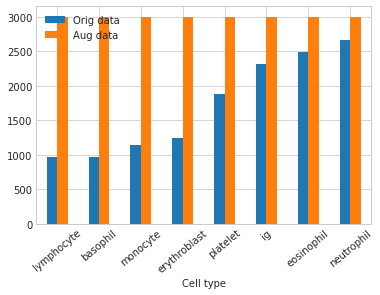

In [24]:
# image count per class after augmentation 
data_dist = {}

for class_abbv, class_full in abbreviation_dict.items():
    data_dist[class_abbv] = [class_full,
                             get_number_of_files(f'{split_data_path}/train/{class_full}'),
                            get_number_of_files(f'{aug_data_path}/{class_full}'),
                             get_number_of_files(f'{split_data_path}/test/{class_full}'),
                             get_number_of_files(f'{split_data_path}/val/{class_full}')]
    
data_dist_df = pd.DataFrame.from_dict(data_dist, 'index', columns=['Cell type','Orig data', 'Aug data',
                                                                   'Test data', 'Val data'])
data_dist_df['%']= data_dist_df['Orig data']/data_dist_df['Orig data'].sum()
data_dist_df.sort_values(by = "%", inplace=True)

data_dist_df.plot.bar(x= 'Cell type', y=['Orig data', 'Aug data'])
plt.xticks(rotation=40)
plt.show()

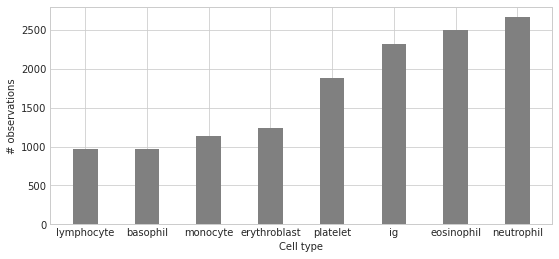

In [53]:
import numpy as np
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9,4))
plt.bar(data_dist_df['Cell type'], data_dist_df['Orig data'],  width=0.4,color = 'grey')
plt.ylabel("# observations")
plt.xlabel("Cell type")
#plt.xticks(rotation=10, ha='right')
plt.savefig('../figures/model2_pbc_ft_observ_cnt.png')
plt.show()

## **Data distribution**

In [16]:
data_dist_df

,Cell type,Orig data,Aug data,Test data,Val data,%
LY,lymphocyte,971,3003,122,121,0.071026
BA,basophil,974,3000,123,121,0.071246
MO,monocyte,1136,3001,142,142,0.083096
ERB,erythroblast,1240,3004,156,155,0.090703
PLATELET,platelet,1878,3003,236,234,0.137371
IG,ig,2316,3000,290,289,0.169410
EO,eosinophil,2493,3005,313,311,0.182357
BNE,neutrophil,2663,3004,334,332,0.194792
